<a href="https://colab.research.google.com/github/MatheusSteinDeAguiar/ChurnModelling/blob/main/ChurnModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Modelling

## Pré-processamento de dados


In [1]:
import pandas as pd

dados = pd.read_csv("/content/Churn_Modelling.csv")
dados.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Análise exploratória de dados com sweetviz

In [2]:
!pip install sweetviz
import sweetviz as sv

     |████████████████████████████████| 15.1 MB 171 kB/s 


In [3]:
eda = sv.analyze(source = dados, target_feat = 'Exited')

                                             |          | [  0%]   00:00 -> (? left)


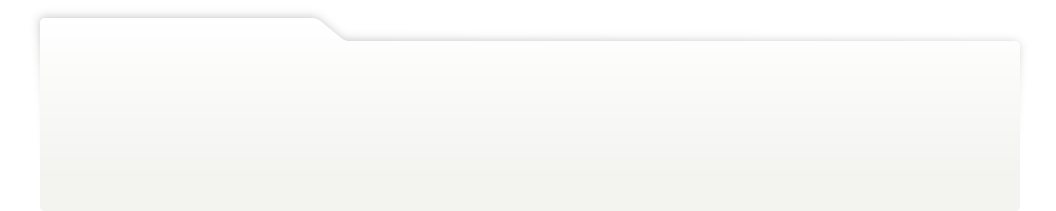
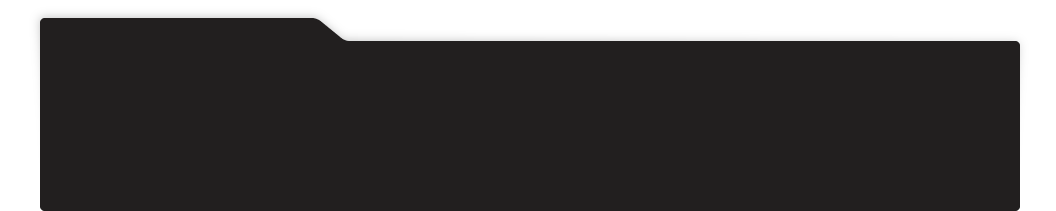
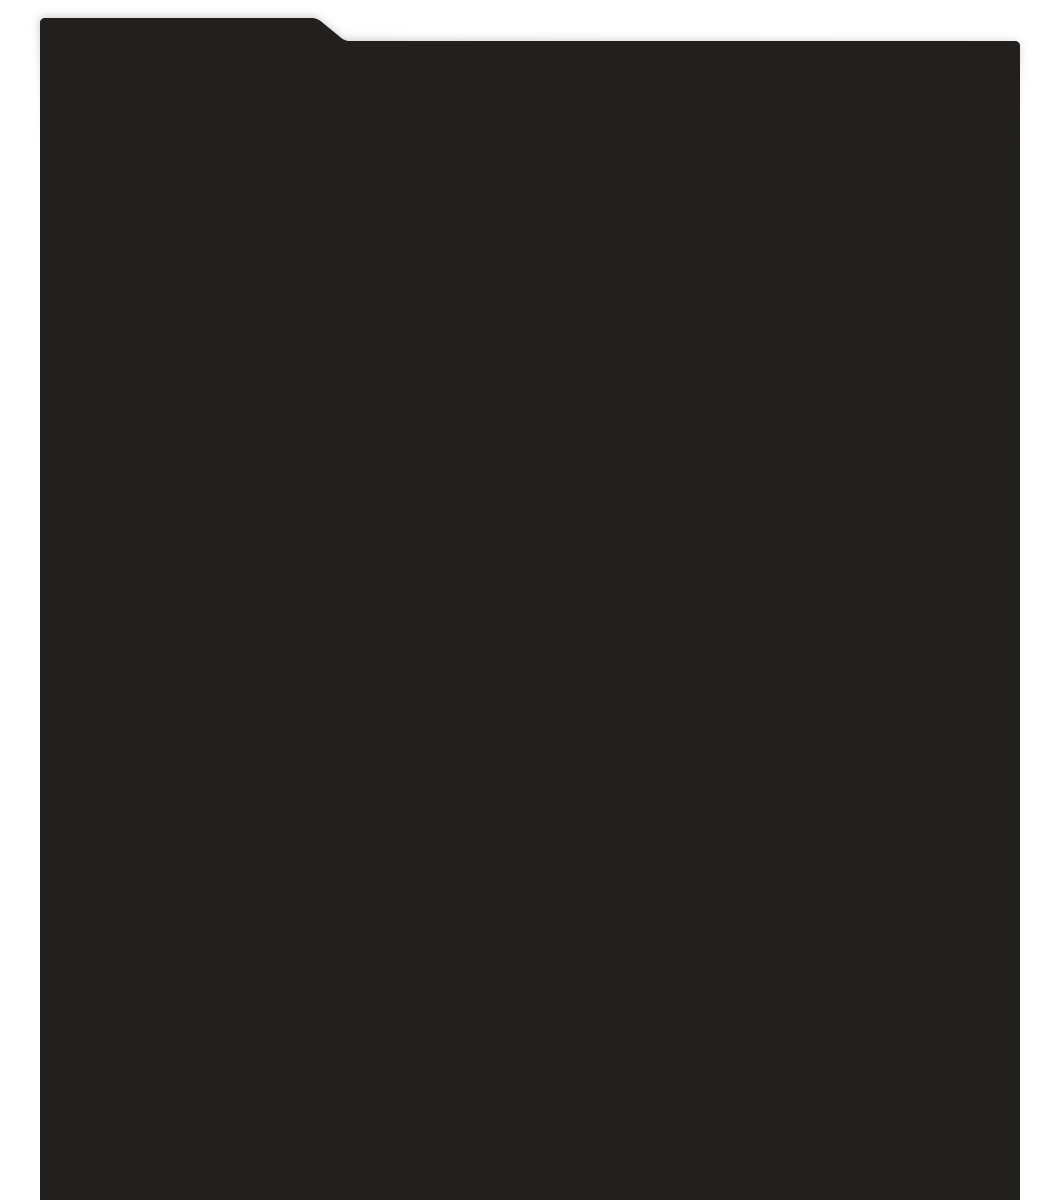
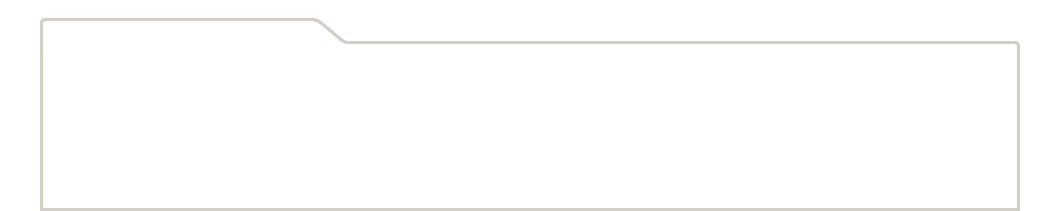
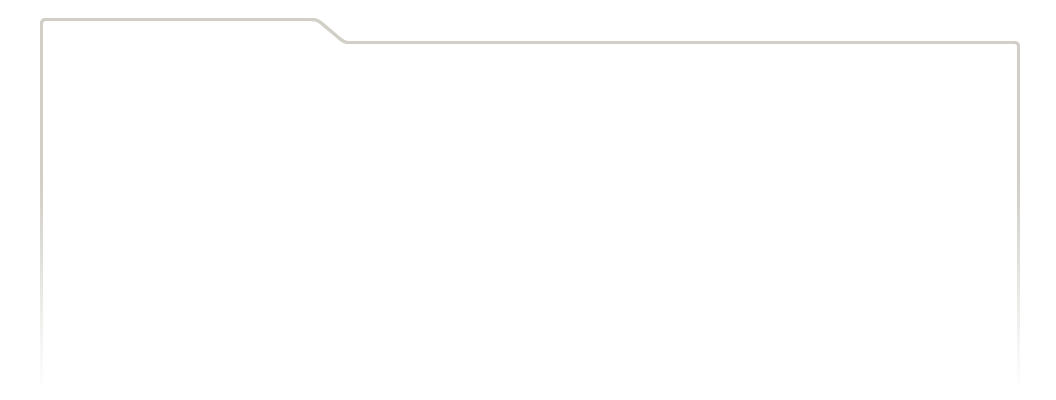
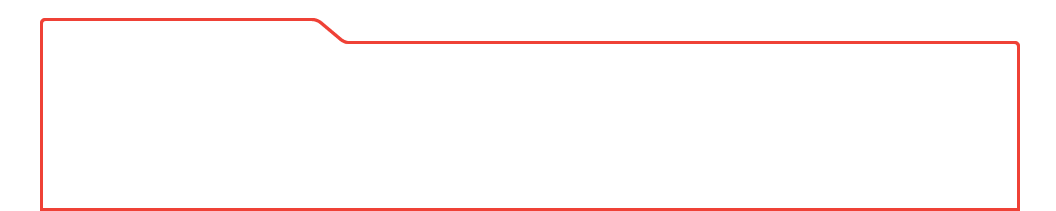
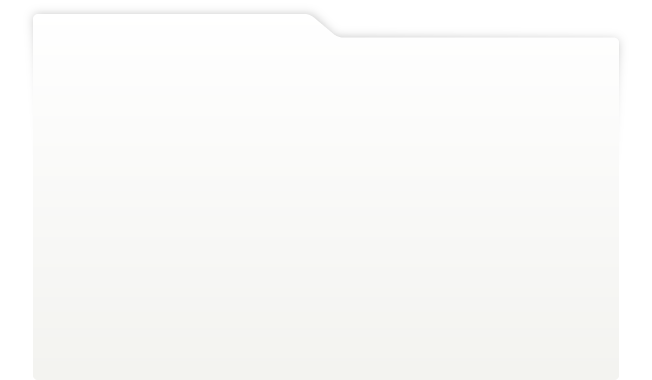
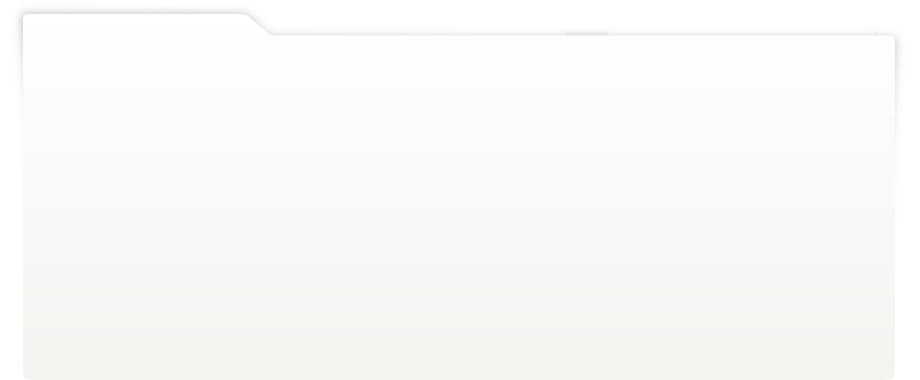
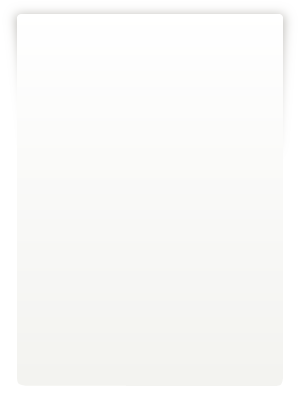
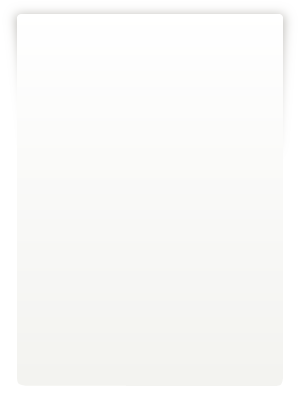
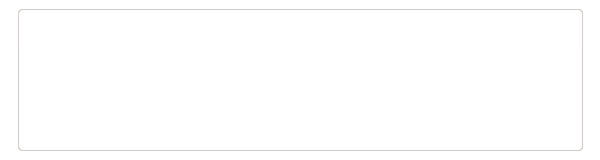
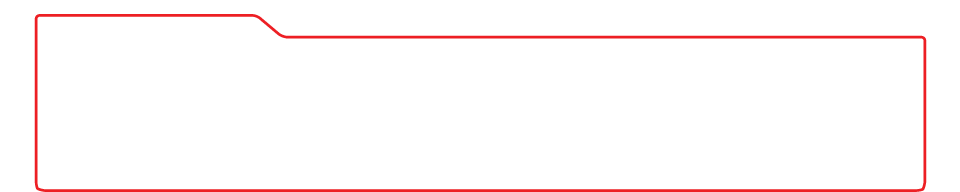
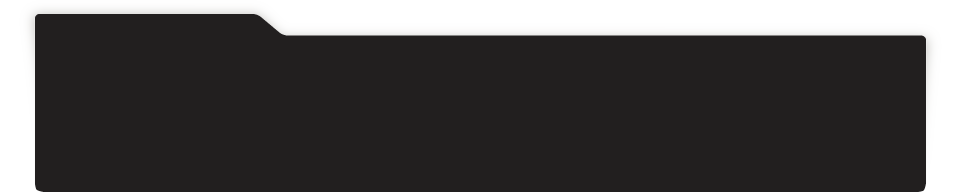
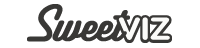
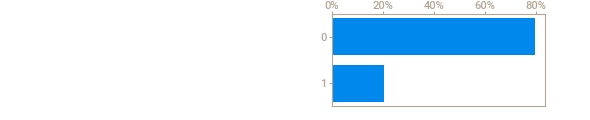
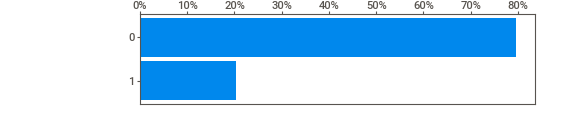
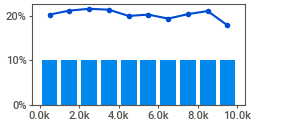
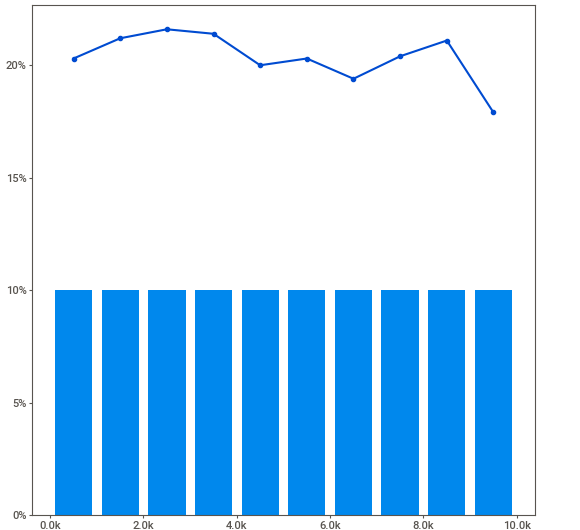
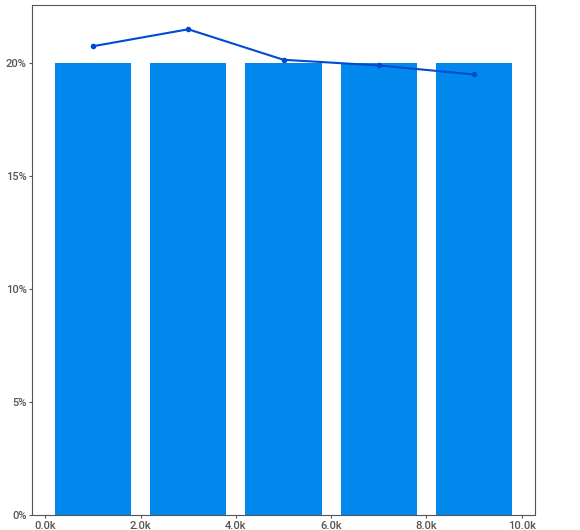
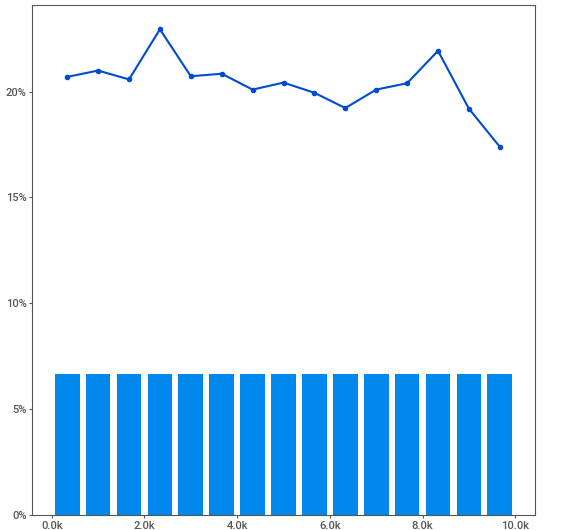
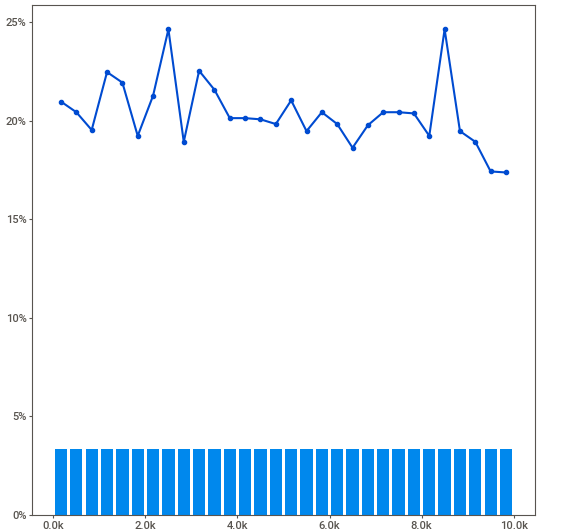
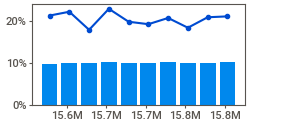
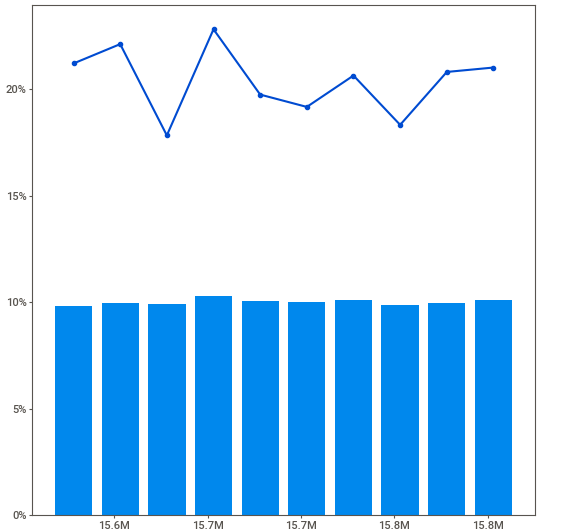
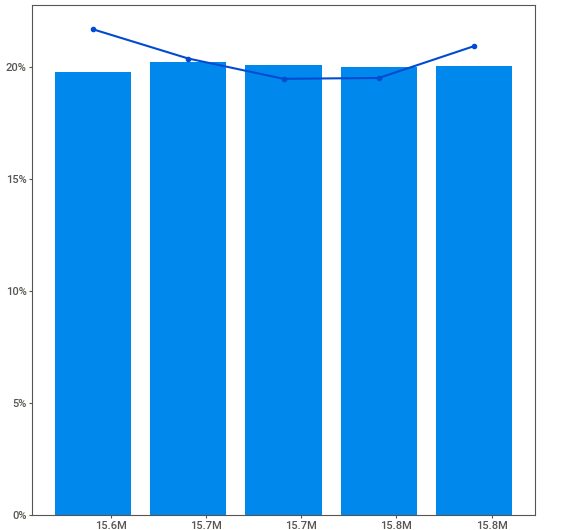
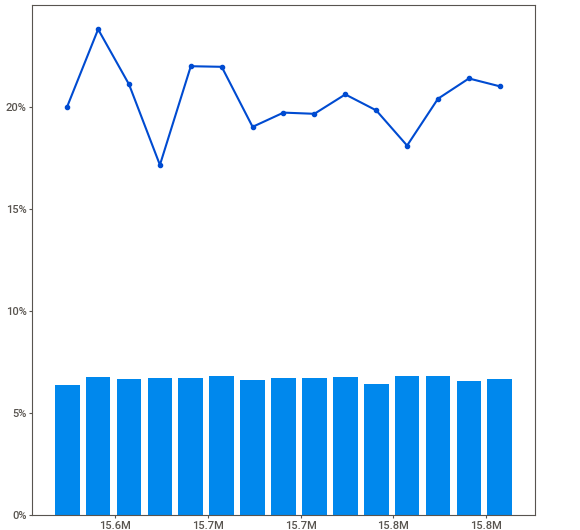
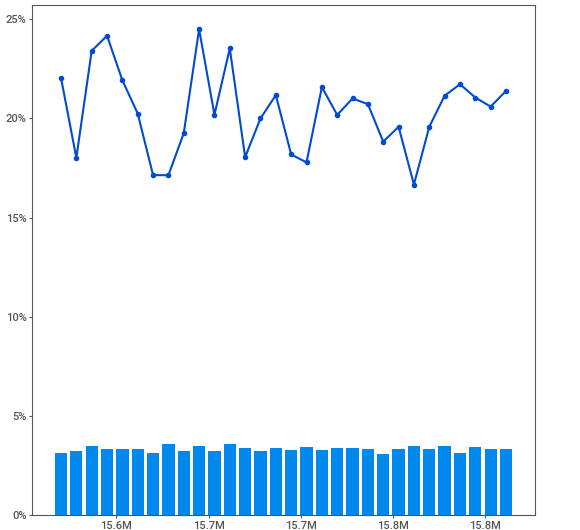
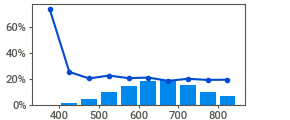
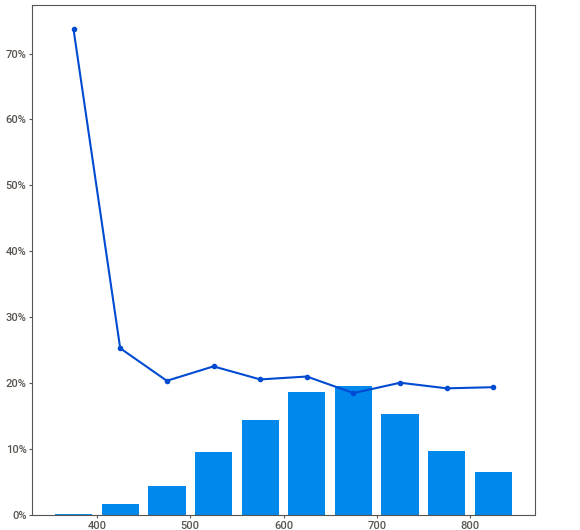
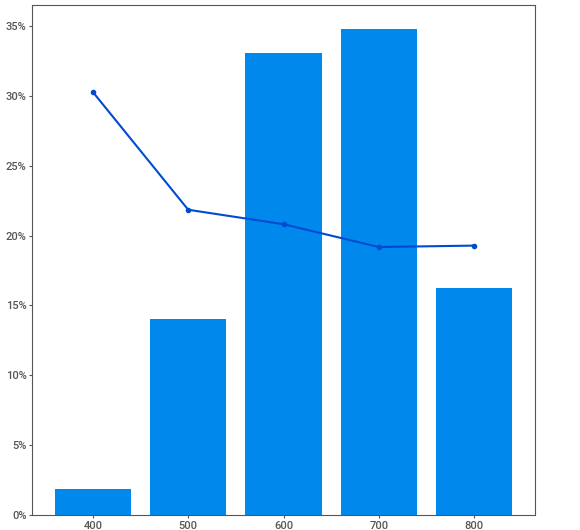
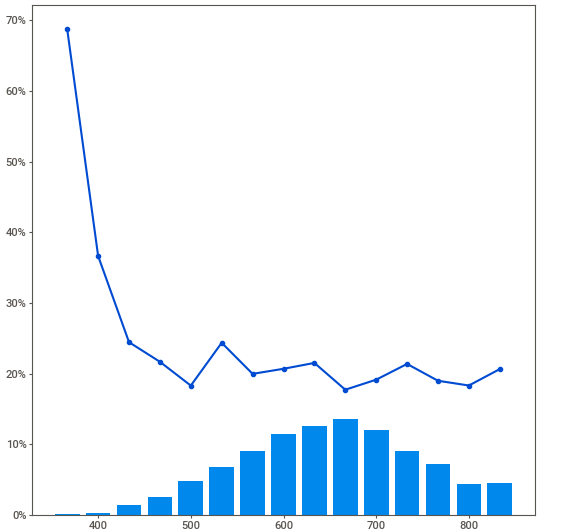
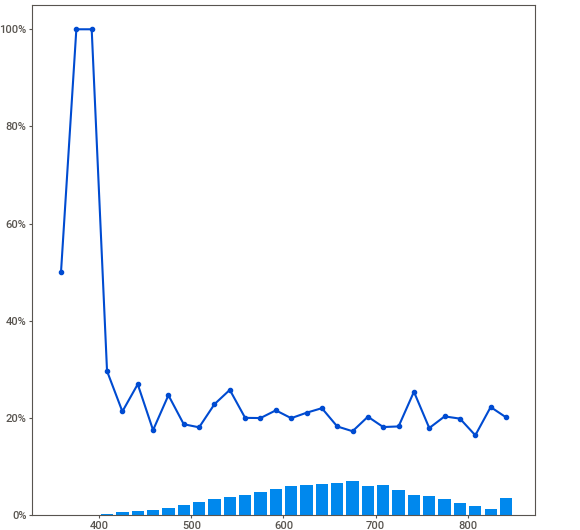
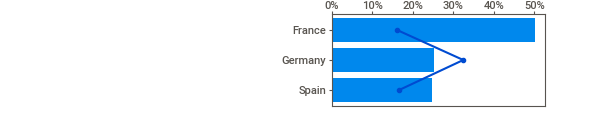
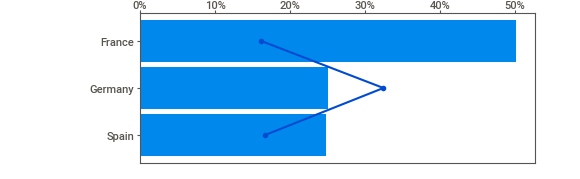
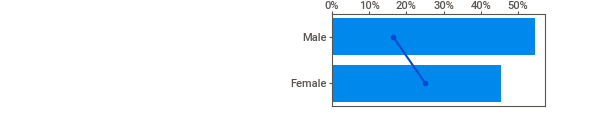
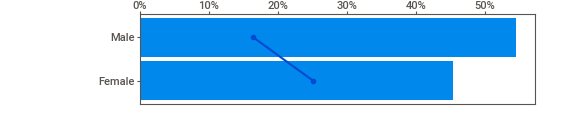
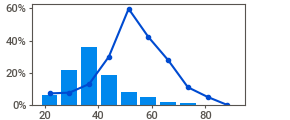
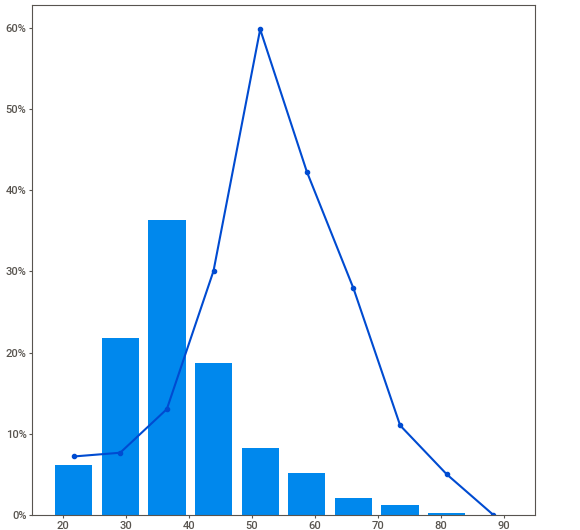
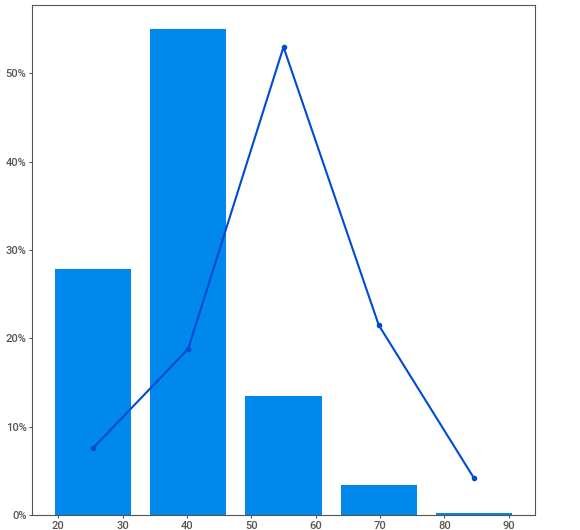
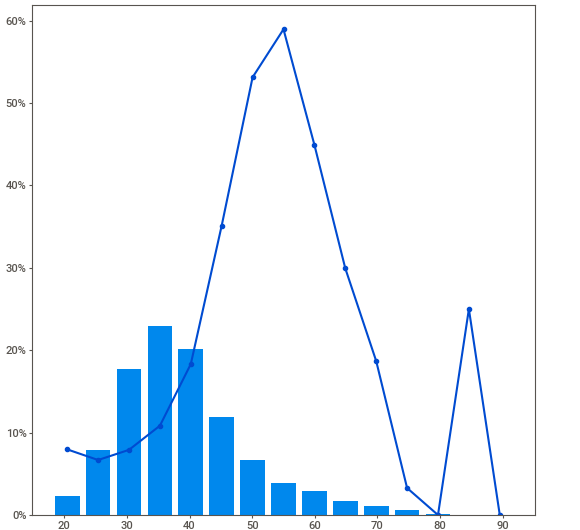
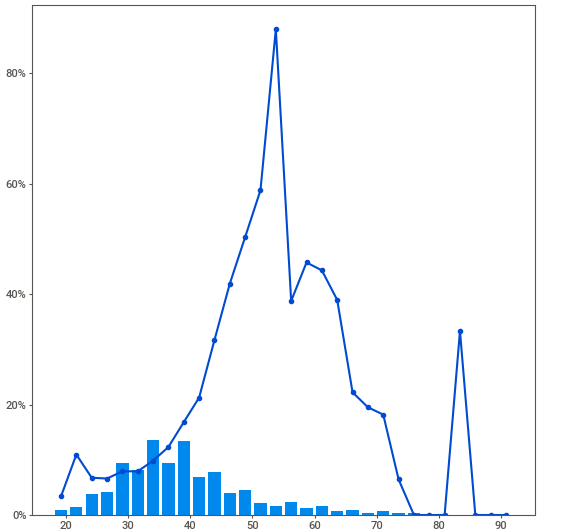
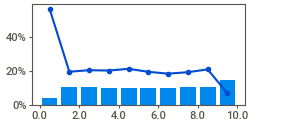
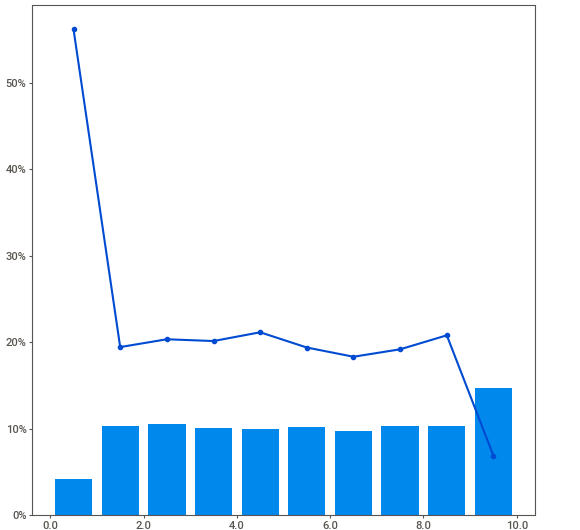
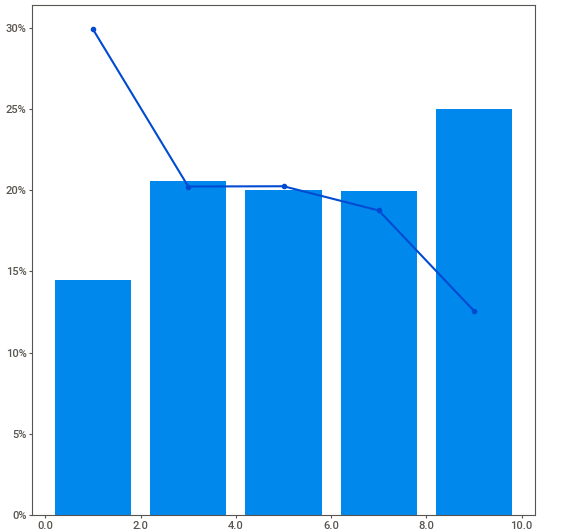
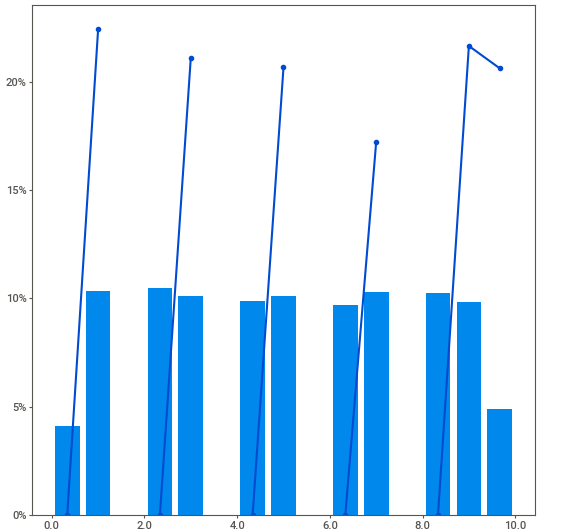
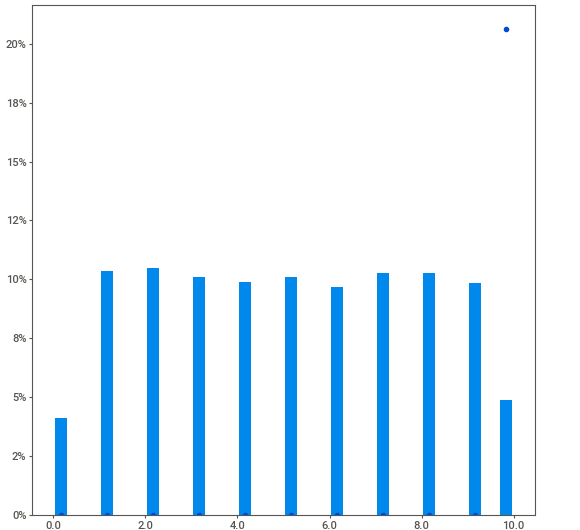
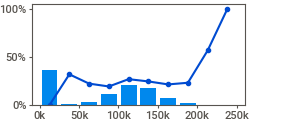
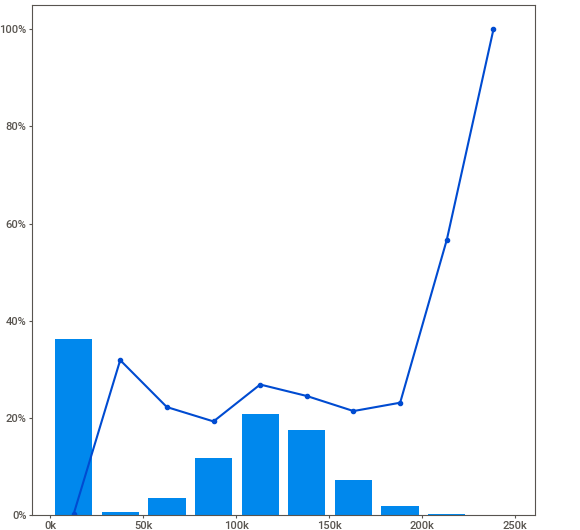
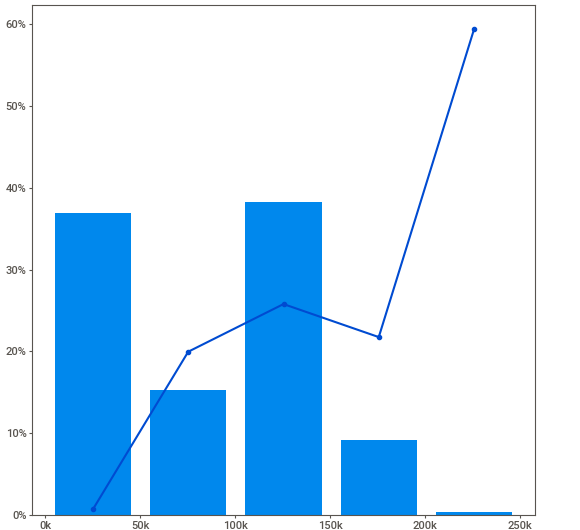
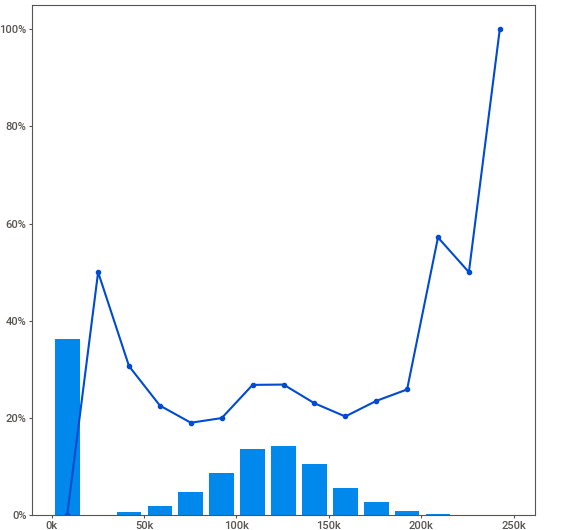
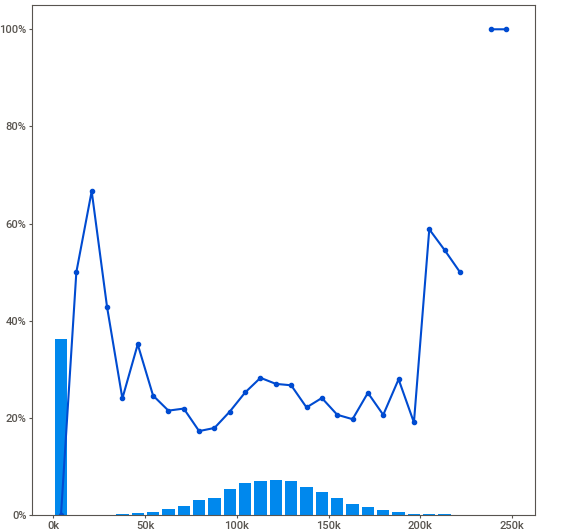
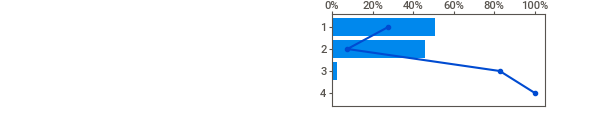
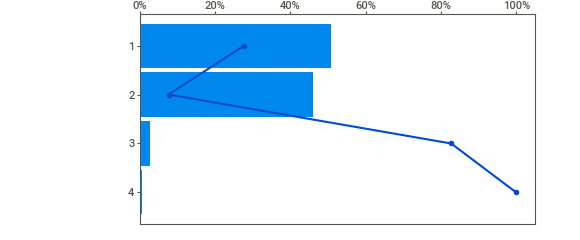
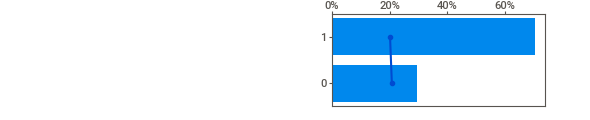
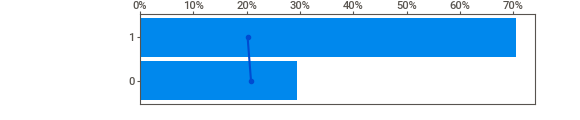
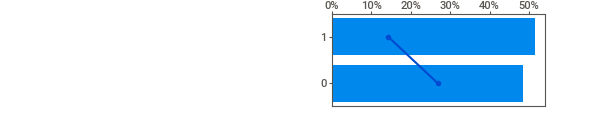
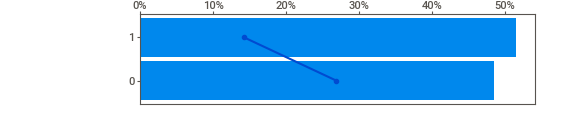
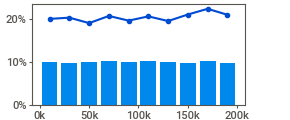
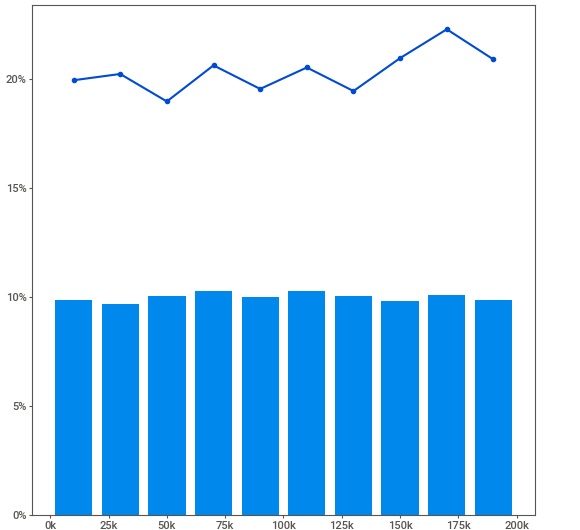
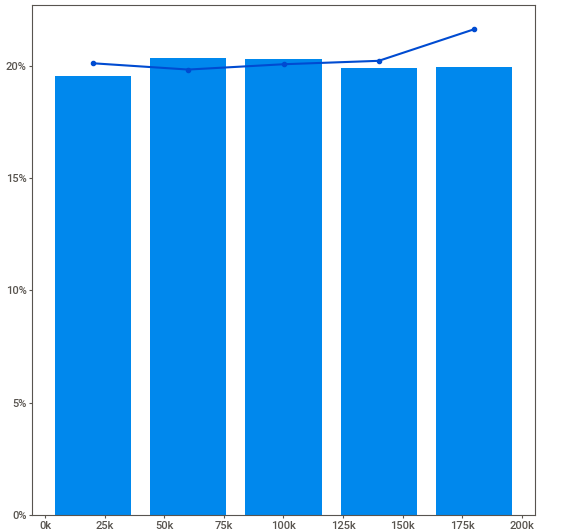
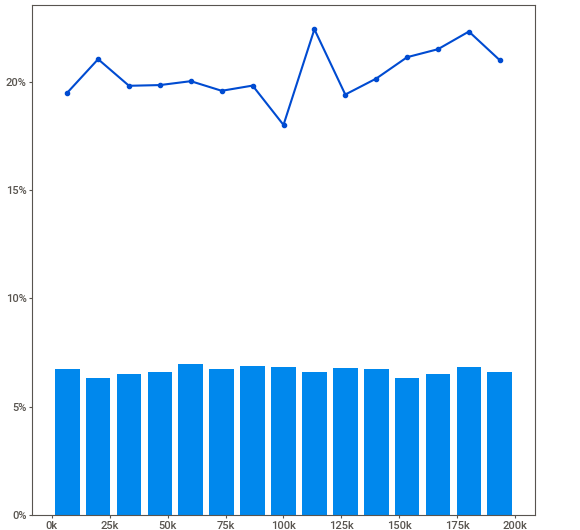
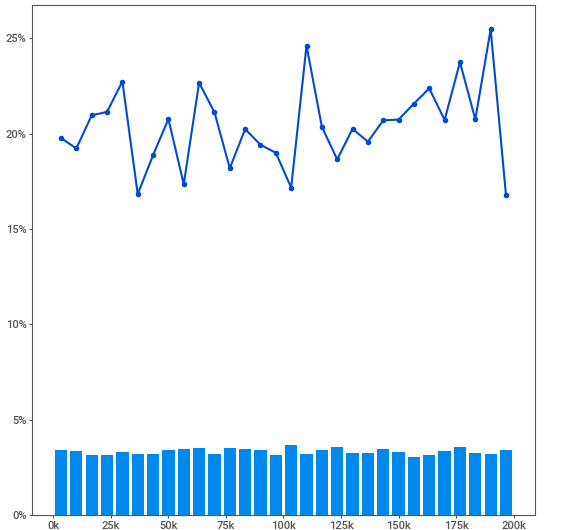
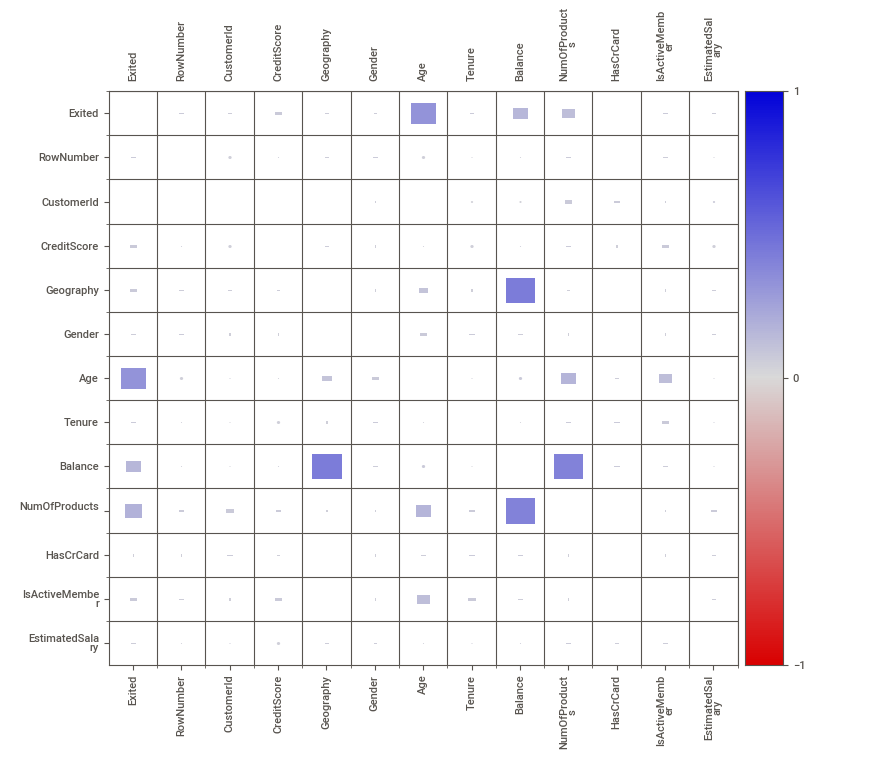
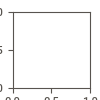

In [4]:
eda.show_notebook()

Através da analise com o sweetviz é possivel fazer as seguintes observações:
- RowNumber, CustomerId e Surname não são variaveis significantes para o modelo e por isso podem ser descartadas.
- Balance, Age e NumOfProducts são as variaveis com maior correlação com o exited que é o que queremos estimar.
- Algumas outras pequenas tendências podem ser observadas, Germany ter mais exited que os outros paises, mulheres terem um pouco mais que os homens, a relação entre membros ativos e não ativos.


## Primeiro pré processamento
### Excluindo variáveis que não serão utilizadas

In [5]:
dados.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace = True)
dados.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Como foi anteriormente falado, aqui foi feita a exclusão de variaveis não informativas.

## Segundo pré processamento
### Verificação de dados nulos

In [6]:
import missingno

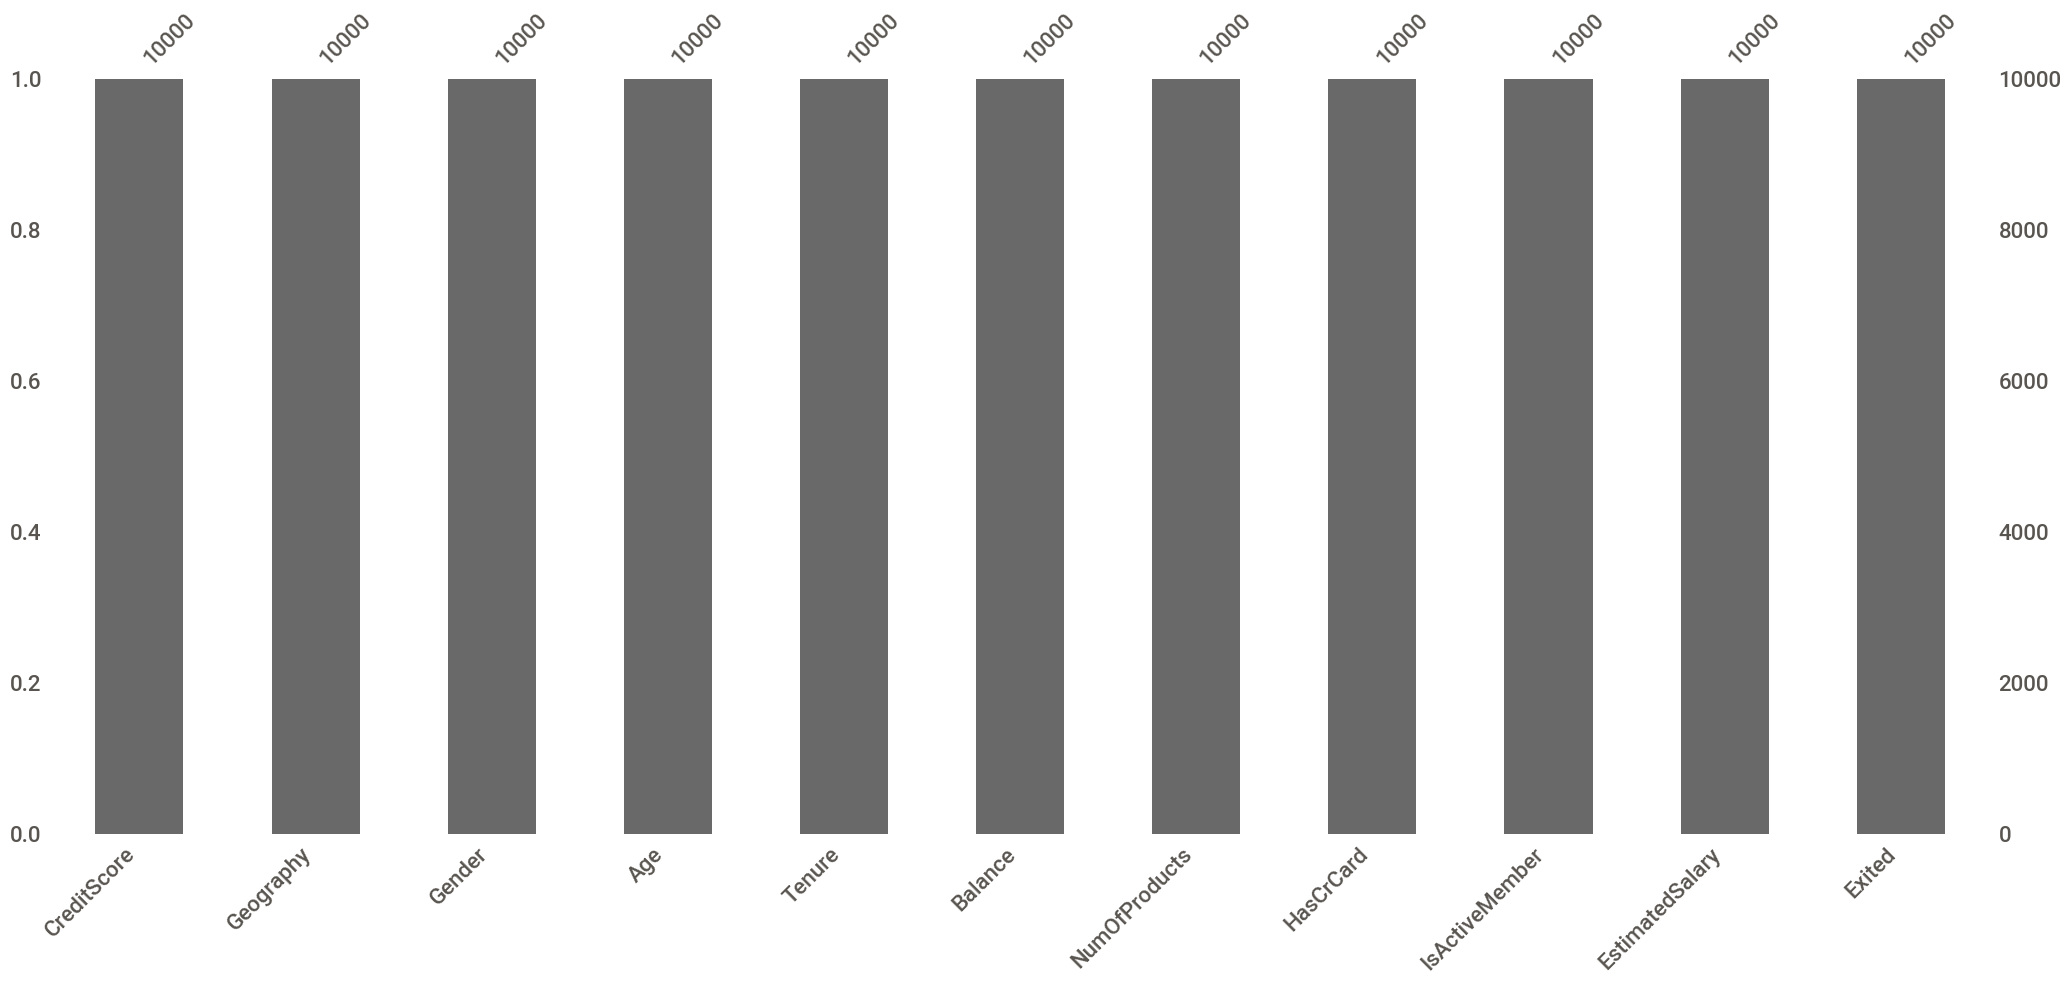

In [7]:
missingno.bar(dados)

Como é possivel observar, não há dados nulos.

## Terceiro pré processamento
### Transformando variaveis continuas em categóricas

In [8]:
def auxiliar(x):
  if x == 0:
    return 'Zerada'
  elif x<100000:
    return 'Até 100k'
  elif x<120000:
    return 'Até 120k'
  elif x<140000:
    return 'Até 140k'
  else:
    return 'Mais de 140k'

dados['Balance'] = dados['Balance'].apply(auxiliar)

Os modelos tendem a interagir melhor com variáveis categóricas, portanto há a necessidade de transformar o Balance em categorias, para melhor definir as categorias foi utilizada a categoria "zerada" pois essa parecia ter uma influência significativa e uma grande ocorrência, e dos outros dados foi feito os quartis e divido desta forma.

## Quarto pré processamento
### Agrupamento de categorias

In [9]:
def auxiliar(x):
  if x == 0:
    return '0'
  elif x<10:
    return '1-9'
  else:
    return '10'

dados['Tenure'] = dados['Tenure'].apply(auxiliar)

Exclusão de categorias "injustificáveis", optou-se por deixar apenas 3 categorias 0 e 10 pois mostravam ter significancia, e as demais foram agrupadas em 1-9

## Quinto pré processamento
### Dummyficação de variaveis

In [10]:
variaveis_cat = ['Geography', 'Tenure', 'Balance', 'NumOfProducts', 'Gender']
dados = pd.get_dummies(dados, columns = variaveis_cat, drop_first=True)
dados.head()

,CreditScore,Age,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Tenure_1-9,Tenure_10,Balance_Até 120k,Balance_Até 140k,Balance_Mais de 140k,Balance_Zerada,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Gender_Male
0,619,42,1,1,101348.88,1,0,0,1,0,0,0,0,1,0,0,0,0
1,608,41,0,1,112542.58,0,0,1,1,0,0,0,0,0,0,0,0,0
2,502,42,1,0,113931.57,1,0,0,1,0,0,0,1,0,0,1,0,0
3,699,39,0,0,93826.63,0,0,0,1,0,0,0,0,1,1,0,0,0
4,850,43,1,1,79084.10,0,0,1,1,0,0,1,0,0,0,0,0,0


Os modelos interagem melhor com variáveis dummyficados, ou seja ao inves de uma coluna dizer se é masculino ou feminino colocamos duas variáveis onde uma vai conter o 1 quando aquela caraterística for verdadeira e na outra 0 visto que é falsa, e assim com n varíaveis. Vale ressaltar que é droppada a primeira coluno visto que por exemplo em Male ou Female, uma linha que tenha 0 em Male é dado por obvio que será Female.

## Sexto pré processamento
### Escalando variaveis contínuas

In [11]:
dados['CreditScore'] = dados['CreditScore']/1000

In [12]:
import numpy as np

#padronização das idades

media = np.mean(dados['Age'])
desvio = np.std(dados['Age'])

dados['Age'] = (dados['Age'] - media) / desvio

In [13]:
dados['EstimatedSalary'] = dados['EstimatedSalary']/100000

É interessante para não confundir os modelos manter os número em escalas menores, variando por exemplo em volta da média como é feito na idade, ou representando em 100000 como foi feito no EstimatedSalary diminuindo assim o impacto dos números na modelagem e mantendo apenas sua relevância.

## Machine Learning

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [15]:
#Balance Accuracy é a média entre a taxa de acerto de 0's (especificidade) e a taxa de acertos de 1's (sensibilidade).
#F1-score baseada na precisão e sensibilidade.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [16]:
X = dados.drop('Exited', axis=1)
y = dados['Exited']

lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
nome_das_medidas = ['Acurácia', 'Sensibilidade', 'Precisão', 'Eficácia', 'f1-score']

lista_de_modelos = [LogisticRegression(),
                    DecisionTreeClassifier(max_depth=3),
                    DecisionTreeClassifier(max_depth=5),
                    DecisionTreeClassifier(max_depth=7),
                    KNeighborsClassifier(n_neighbors=5),
                    KNeighborsClassifier(n_neighbors=15),
                    KNeighborsClassifier(n_neighbors=25),
                    BaggingClassifier(),
                    RandomForestClassifier(n_estimators=50, max_depth=5),
                    RandomForestClassifier(n_estimators=50, max_depth=7),
                    RandomForestClassifier(n_estimators=100, max_depth=5),
                    RandomForestClassifier(n_estimators=100, max_depth=7)]

nome_dos_modelos = ['Regressão Logística',
                    'Arvore prof = 3',
                    'Arvore prof = 5',
                    'Arvore prof = 7',
                    '5-knn',
                    '15-knn',
                    '25-knn',
                    'Bagging',
                    'Random Forest 50 arv prof 5',
                    'Random Forest 50 arv prof 7',
                    'Random Forest 100 arv prof 5',
                    'Random Forest 100 arv prof 7']

resultados0 = {}

validacao = StratifiedKFold(n_splits=10)

for i in range(len(lista_de_modelos)):
  print("Rodando modelo: " + nome_dos_modelos[i])
  accs_vc = cross_validate(lista_de_modelos[i], X, y, cv = validacao, scoring= lista_de_medidas)

  acc = accs_vc['test_accuracy'].mean()
  sen = accs_vc['test_recall'].mean()
  vpp = accs_vc['test_precision'].mean()
  bac = accs_vc['test_balanced_accuracy'].mean()
  f1s = accs_vc['test_f1'].mean()

  resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, bac, f1s]

resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

Rodando modelo: Regressão Logística
Rodando modelo: Arvore prof = 3
Rodando modelo: Arvore prof = 5
Rodando modelo: Arvore prof = 7
Rodando modelo: 5-knn
Rodando modelo: 15-knn
Rodando modelo: 25-knn
Rodando modelo: Bagging
Rodando modelo: Random Forest 50 arv prof 5
Rodando modelo: Random Forest 50 arv prof 7
Rodando modelo: Random Forest 100 arv prof 5
Rodando modelo: Random Forest 100 arv prof 7


In [17]:
resultados.sort_values(by='f1-score', ascending=False)

,Acurácia,Sensibilidade,Precisão,Eficácia,f1-score
Arvore prof = 7,0.8522,0.457520,0.717803,0.705338,0.556657
Random Forest 50 arv prof 7,0.8603,0.412832,0.806234,0.693795,0.544987
Random Forest 100 arv prof 7,0.8609,0.407949,0.818142,0.692359,0.543433
Bagging,0.8466,0.449184,0.691110,0.698721,0.543401
Arvore prof = 5,0.8511,0.429593,0.732899,0.694266,0.537753
15-knn,0.8510,0.404535,0.749599,0.684875,0.523958
5-knn,0.8367,0.418244,0.656016,0.680992,0.509870
25-knn,0.8494,0.384876,0.756760,0.676552,0.508767
Regressão Logística,0.8419,0.381435,0.707971,0.670561,0.494918
Arvore prof = 3,0.8439,0.360311,0.739364,0.663956,0.484103


Nesse modelo a métrica principal seria o F1-score, que por definição contempla a sensibilidade e a precisão. Visto que em média 80% dos casos não dão churn e o objetivo é justamente prever aqueles que dão, é muito mais interessante observar os casos onde o modelo preveu 1 do que simplesmente analisar a acurácia visto que um modelo que classficasse todos como 0 já teria acurácia de 80%.

O melhor modelo encontrado sozinho foi a Decision Tree de prof = 7, esta atingiu sensibilidade 45,9 ou seja conseguiu prever 45.9% dos casos de churn e obteve precisão de 71,9 ou seja 7 de cada 10 vezes em que o modelo preveu o churn ele estava correto.



## Testando combinação de modelos

In [27]:
from sklearn.ensemble import VotingClassifier

profundidade = 7
k = 15

reglog = LogisticRegression()
tree = DecisionTreeClassifier(max_depth = profundidade)
knn = KNeighborsClassifier(n_neighbors = k)
rf = RandomForestClassifier(n_estimators=50, max_depth=7)
rf2 = RandomForestClassifier(n_estimators=100, max_depth=5)

modelos = [('Reg Log', reglog), ('Decision Tree', tree), ('KNN', knn), ('Rf', rf), ('Rf2', rf2)]

modelo = VotingClassifier(modelos, voting = 'hard')
medidas = cross_validate(modelo, X, y, cv = validacao, scoring='f1')
medidas['test_score'].mean()

0.528318702536372

In [29]:
modelo = VotingClassifier(modelos, voting = 'soft')
medidas = cross_validate(modelo, X, y, cv = validacao, scoring='f1')
medidas['test_score'].mean()

0.5331969445480934

Com os testes que foram executados nennhuma combinação de modelos conseguiu bater o f1 atingido pela DecisionTree de profundidade 7.